In [1]:
# 필요한 package들을 import 한다. 
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T


# device 설정
# GPU를 사용할 수 있으면 사용하고, 아니면 CPU를 사용한다.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

# Replay Memory

In [2]:
# namedtuple은 key와 index를 통해 값에 접근할 수 있다.
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


# ReplayMemory를 정의
class ReplayMemory(object):
    def __init__(self, capacity):
        # deque는 양방향 queue를 의미한다.
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        # Transition을 저장하는 부분이다.
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        # memory로부터 batch_size 길이 만큼의 list를 반환한다.
        return random.sample(self.memory, batch_size)

    def __len__(self):
        # memory의 길이를 반환한다.
        return len(self.memory)

# Network

In [3]:
class net(nn.Module):
    def __init__(self, outputs):
        super(net, self).__init__()
        self.fc1 = nn.Linear(4, 24)
        self.fc2 = nn.Linear(24, 24)
        self.fc3 = nn.Linear(24, outputs)

    def forward(self, x):
#         x = x.to(device)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Functions

In [4]:
def select_action(state, epsilon):

    sample = random.random()

    if sample > epsilon:
#         with torch.no_grad():
        return policy_net(state).max(1)[1].view(1,1)

    else:
        # tensor([['index']])의 형식으로 random하게 action이 선택된다. 
        # 즉, 0 이나 1 값이 선택됨.
        return torch.tensor([[random.randrange(n_actions)]], device=device, \
        dtype=torch.long)

# Model training

In [5]:
def train_model():
    if len(memory) < BATCH_SIZE:
        return

 
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))
    
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    next_state_batch = torch.cat(batch.next_state)
    reward_batch = torch.cat(batch.reward)
    


    current_q_values = policy_net(state_batch).gather(1, action_batch)
    max_next_q_values = target_net(next_state_batch).detach().max(1)[0]
    target_q_values = reward_batch + (GAMMA * max_next_q_values)

#     # Huber Loss 계산
#     criterion = nn.SmoothL1Loss()
# #     criterion = F.smooth_l1_loss()
#     loss = criterion(current_q_values, target_q_values) # unsqueeze(): 차원 추가 
    loss = F.mse_loss(current_q_values.squeeze(), target_q_values)    

    # Optimize parameters
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        # 모든 원소를 [ min, max ]의 범위로 clamp
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

# Main

## Hyperparameters

In [6]:
# ==== Hyperparameters ==== #
BATCH_SIZE = 32
GAMMA = 0.98
# EPS_START = 0.9
# EPS_END = 0.05
# EPS_DECAY = 200
TARGET_UPDATE = 1
LR = 0.0005
# ========================== #

## Model loading

In [7]:
env = gym.make('CartPole-v1')

# gym의 action space에서 action의 가짓수를 얻는다.
# n_actions >> 2
n_actions = env.action_space.n

# network
policy_net = net(n_actions).to(device)
target_net = net(n_actions).to(device)

# policy network의 network parameter를 불러온다.   
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
optimizer = optim.Adam(policy_net.parameters(), LR)

# Capacity (즉, maximum length) 2000짜리 deque 이다.
memory = ReplayMemory(2000)

steps_done = 0
score_avg = 0
scores, episodes = [], []
train_start = 2000
HM_EPISODES = 10_000
SHOW_EVERY = 20
score = 0
steps = 0


episode:  20 | score: 10.2 | memory lengh:  203 | eps: 8.0%
episode:  40 | score: 9.9 | memory lengh:  401 | eps: 8.0%
episode:  60 | score: 9.6 | memory lengh:  592 | eps: 8.0%
episode:  80 | score: 9.8 | memory lengh:  788 | eps: 8.0%
episode: 100 | score: 9.6 | memory lengh:  979 | eps: 8.0%
episode: 120 | score: 9.6 | memory lengh: 1171 | eps: 8.0%
episode: 140 | score: 9.7 | memory lengh: 1364 | eps: 8.0%
episode: 160 | score: 9.8 | memory lengh: 1560 | eps: 8.0%
episode: 180 | score: 10.1 | memory lengh: 1761 | eps: 8.0%
episode: 200 | score: 9.9 | memory lengh: 1959 | eps: 8.0%
episode: 220 | score: 9.5 | memory lengh: 2149 | eps: 8.0%
episode: 240 | score: 10.1 | memory lengh: 2351 | eps: 8.0%
episode: 260 | score: 9.6 | memory lengh: 2542 | eps: 7.9%
episode: 280 | score: 9.8 | memory lengh: 2739 | eps: 7.9%
episode: 300 | score: 9.8 | memory lengh: 2934 | eps: 7.9%
episode: 320 | score: 9.9 | memory lengh: 3132 | eps: 7.9%
episode: 340 | score: 9.6 | memory lengh: 3323 | eps:

episode: 2760 | score: 9.6 | memory lengh: 26954 | eps: 7.4%
episode: 2780 | score: 9.6 | memory lengh: 27145 | eps: 7.4%
episode: 2800 | score: 10.1 | memory lengh: 27347 | eps: 7.4%
episode: 2820 | score: 9.7 | memory lengh: 27541 | eps: 7.4%
episode: 2840 | score: 9.7 | memory lengh: 27734 | eps: 7.4%
episode: 2860 | score: 10.0 | memory lengh: 27934 | eps: 7.4%
episode: 2880 | score: 10.2 | memory lengh: 28139 | eps: 7.4%
episode: 2900 | score: 9.6 | memory lengh: 28331 | eps: 7.4%


KeyboardInterrupt: 

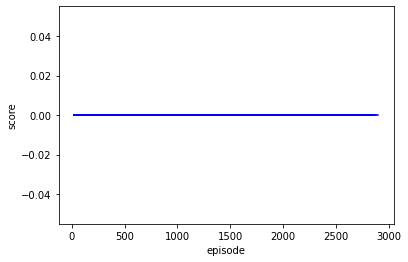

In [8]:
for episode in range(HM_EPISODES):            
    epsilon = max(0.01, 0.08 - 0.01*(episode/5000))  
    state = env.reset()         
    state = torch.tensor([state], device=device, dtype =torch.float) # state에 차원하나 추가 필요
    done = False

    while not done:        

        action = select_action(state, epsilon)    # action result >> tensor([[0]]) or tensor([[1]])

        # 선택한 action을 대입하여 reward와 done을 얻어낸다. 
        # env.step(action.item())의 예시  
        # >> (array([-0.008956, -0.160571,  0.005936,  0.302326]), 1.0, False, {})
        next_state, reward, done, _ = env.step(action.item())     
        score += reward

        reward = torch.tensor([reward], device=device, dtype = torch.float)
        next_state = torch.tensor([next_state], device=device, dtype =torch.float)                

        # 얻어낸 transition set을 memory에 저장
        memory.push(state, action, next_state, reward)
        # (policy network에서) 최적화 한단계 수행



        # 다음 상태로 이동
        state = next_state
        steps += 1


        # 마찬가지로 done이 True 라면,
        if done:
            break

    if len(memory) >= train_start:
        train_model()
        
    if episode % SHOW_EVERY==0 and episode != 0:
        target_net.load_state_dict(policy_net.state_dict())        
        print('episode: {:3d} | score: {:.1f} | memory lengh: {:4d} | eps: {:.1f}%'.format(
            episode, score/SHOW_EVERY, len(memory), epsilon*100))
        
        scores.append(score_avg)
        episodes.append(episode)
        plt.plot(episodes, scores, 'b')
        plt.xlabel('episode')
        plt.ylabel('score')
        score = 0        
env.close()

# 학습 마무리. 
print('Complete')
scores.clear
episodes.clear

